توضیح فایل‌های پروژه:

Models.py:

 در این فایل، مدل‌های مورد نیاز برای حل مسئله‌ی فازی قرار گرفته شده‌اند. از جمله‌ی این مدل‌ها می‌توان به
 
 FuzzyRule
 FuzzyVar
 FuzzySet
 
 اشاره کنیم، که به ترتیب یک قاعده‌ی فازی، یک متغیر فازی و یک مجموعه‌ی فازی را نشان می‌دهند. برای سادگی، متغیرهای فازی تنها از توابع تعلق خطی یا مثلثی پشتیبانی می‌کنند.
 
 
 Controllers.py:
 
 در این فایل، کلاس کنترلر قرار می‌گیرد، که از ۳ متد اصلی زیر تشکیل شده است.
 
 read_fuzzy_problem
 infer
 defuzzify
 
متد اول، شرایط مسئله را به صورت یک فایل یمل می‌خواند، تابع دوم بنا به قواعد داده شده استنتاج انجام داده، و تابع سوم به روش مرکز جرم عمل غیرفازی‌سازی را انجام می‌دهد.

در این پروژه، مسئله‌ی


Tipping Problem


را بررسی می‌کنیم، تا نحوه‌ی عملکرد یک سیستم خبره‌ی فازی، بنا بر یک سری قانون منطقی را تحلیل کنیم.

متغیرهای ورودی مسئله‌ی انعام عبارتند از
۱. کیفیت غذا
۲. کیفیت سرویس

و متغیر خروجی هم عبارت است از
میزان انعام دریافت شده بر حسب درصد

در ابتدا متغیرهای ذکر شده را مدل‌سازی کرده، و آن‌ها را به صورت نمودار به تصویر می‌کشیم.

In [9]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

کیفیت‌ها را به صورت اعدادی بین ۰ تا ۱۰ در نظر گرفته، و درصد انعام را هم بین ۰ تا ۲۵ فرض می‌کنیم.

In [10]:
# Generate universe variables
#   * Quality and service on subjective ranges [0, 10]
#   * Tip has a range of [0, 25] in units of percentage points
x_qual = np.arange(0, 11, 1)
x_serv = np.arange(0, 11, 1)
x_tip  = np.arange(0, 26, 1)

حال مقادیر ورودی را به صورت توابع تعلق فازی مدل می‌کنیم.

In [12]:
# Generate fuzzy membership functions
qual_lo = fuzz.trimf(x_qual, [0, 0, 5])
qual_md = fuzz.trimf(x_qual, [0, 5, 10])
qual_hi = fuzz.trimf(x_qual, [5, 10, 10])

serv_lo = fuzz.trimf(x_serv, [0, 0, 5])
serv_md = fuzz.trimf(x_serv, [0, 5, 10])
serv_hi = fuzz.trimf(x_serv, [5, 10, 10])

tip_lo = fuzz.trimf(x_tip, [0, 0, 13])
tip_md = fuzz.trimf(x_tip, [0, 13, 25])
tip_hi = fuzz.trimf(x_tip, [13, 25, 25])

اکنون می‌توانیم این توابع فازی را به کمک کتابخانه‌ی سیبورن، مصورسازی کنیم.

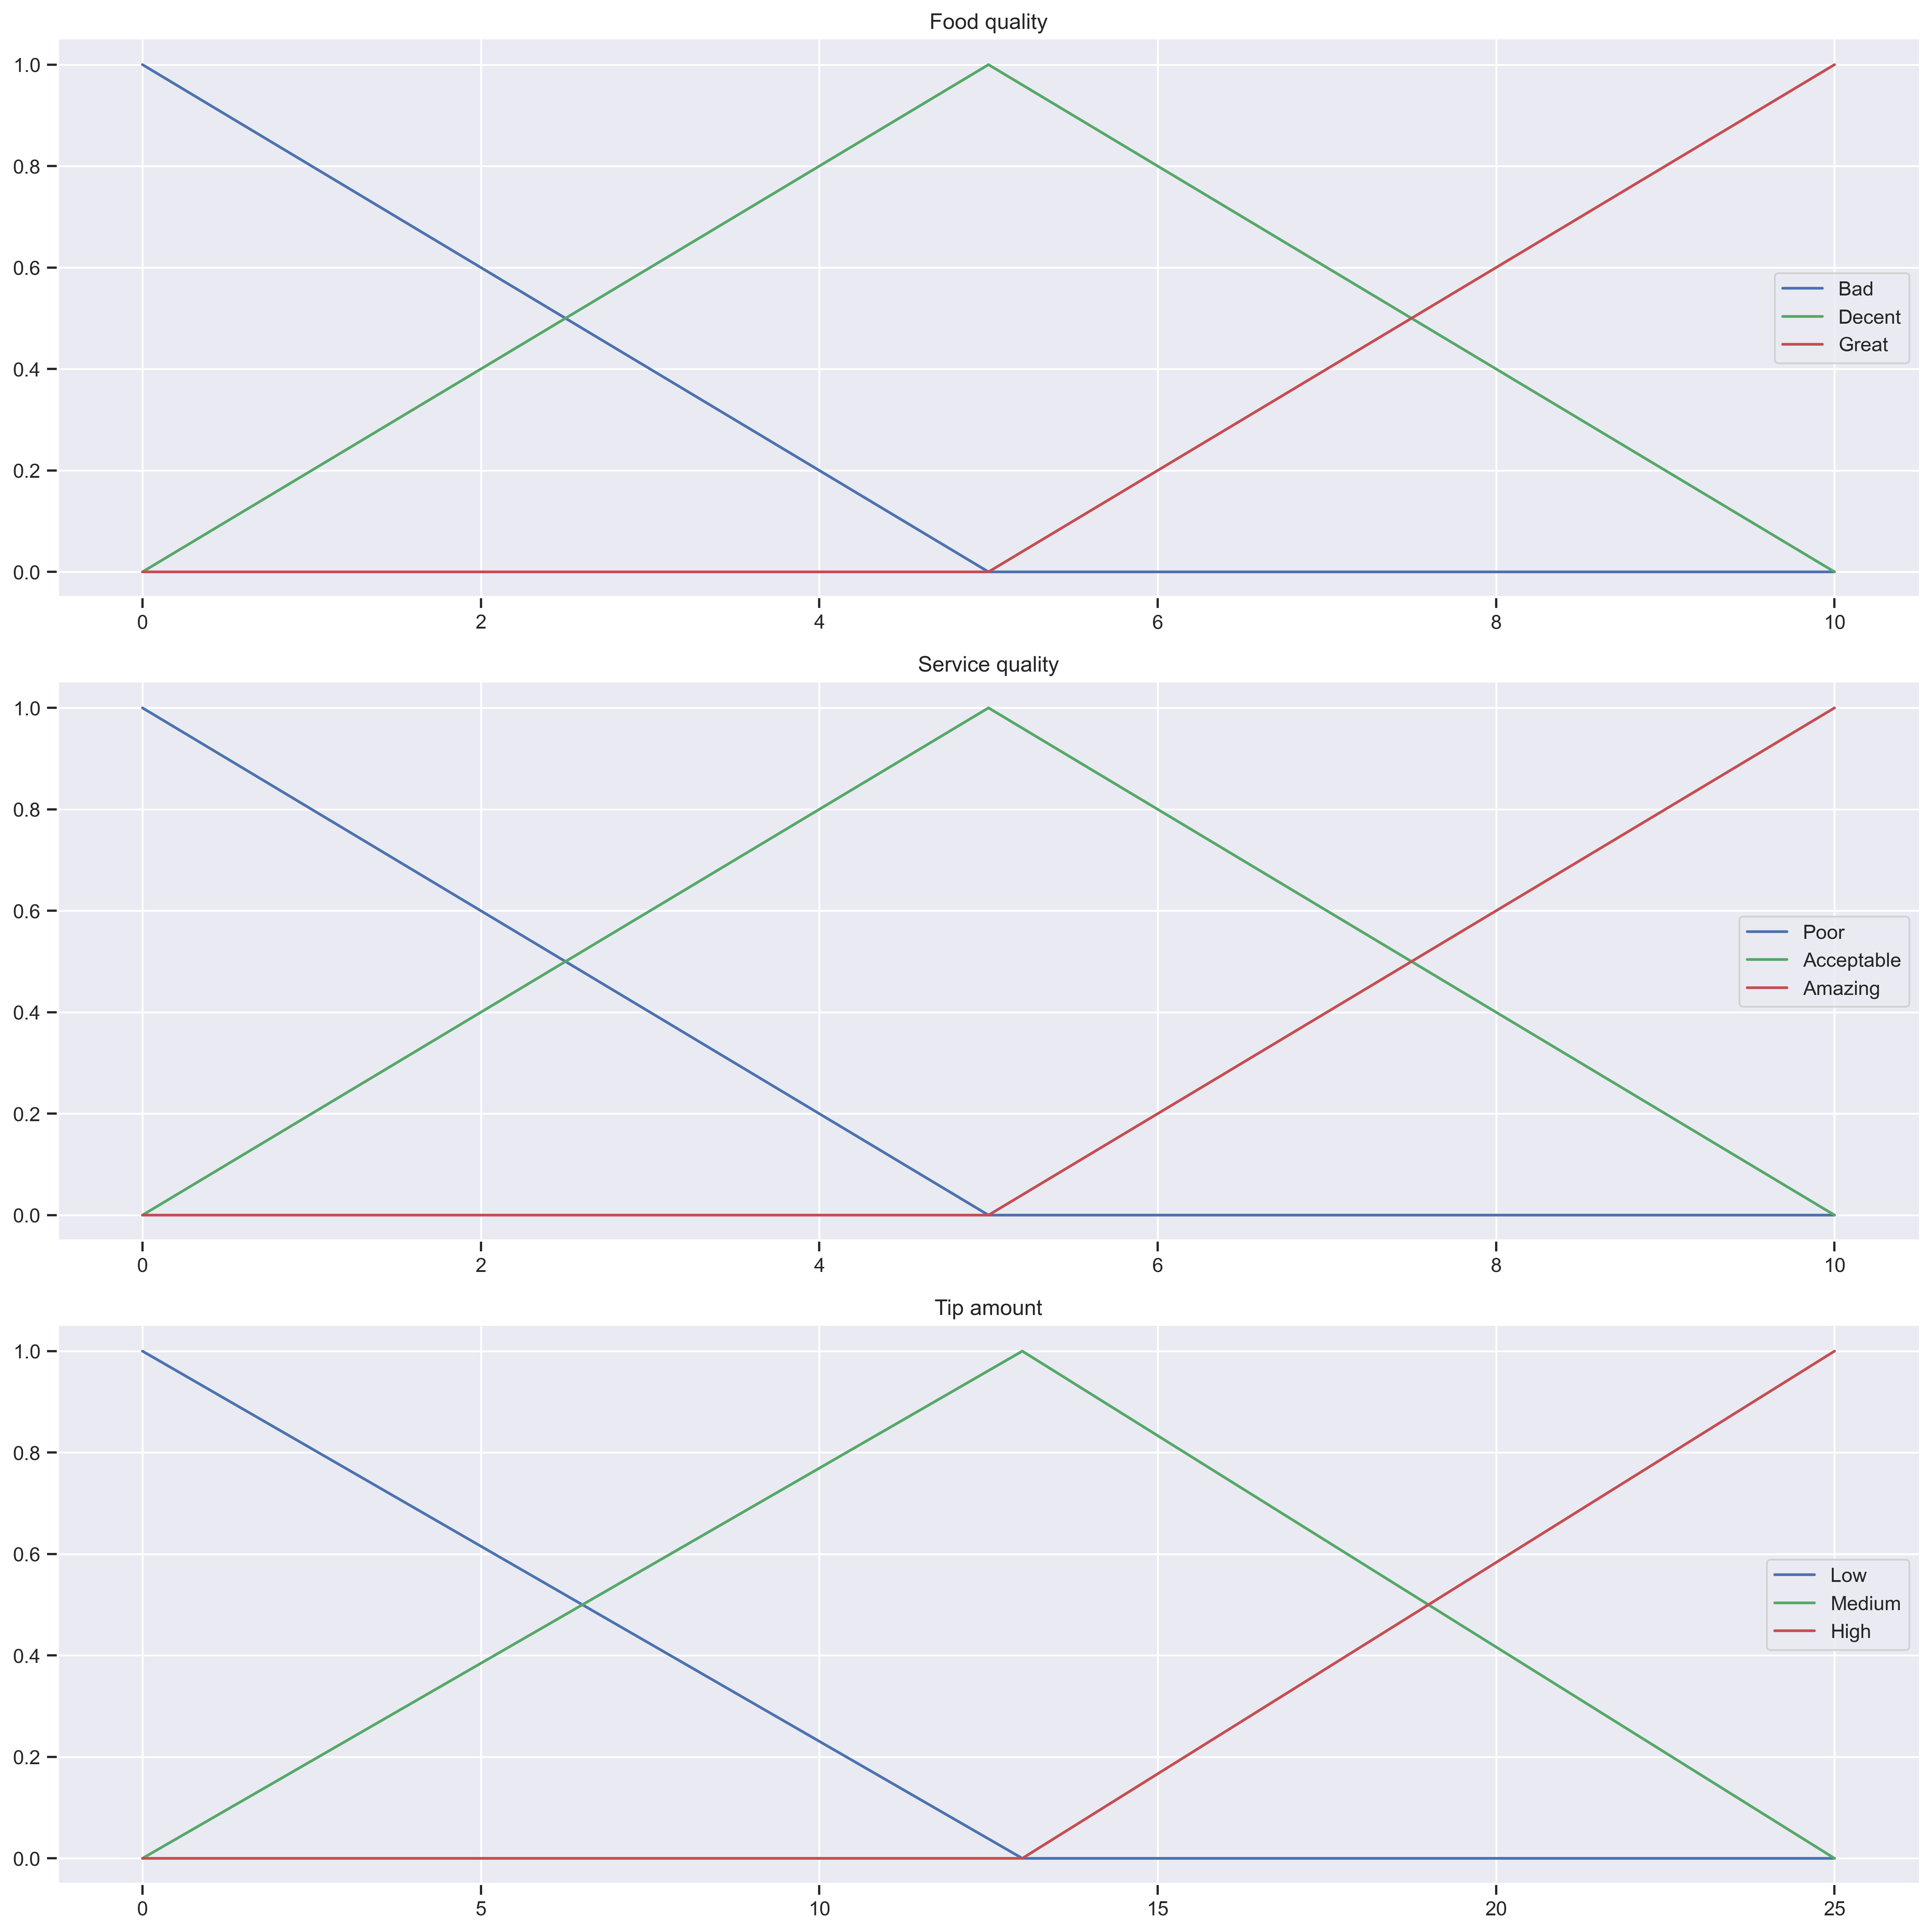

In [15]:
# Visualize these universes and membership functions
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 15), dpi=360)

ax0.plot(x_qual, qual_lo, 'b', linewidth=1.5, label='Bad')
ax0.plot(x_qual, qual_md, 'g', linewidth=1.5, label='Decent')
ax0.plot(x_qual, qual_hi, 'r', linewidth=1.5, label='Great')
ax0.set_title('Food quality')
ax0.legend()

ax1.plot(x_serv, serv_lo, 'b', linewidth=1.5, label='Poor')
ax1.plot(x_serv, serv_md, 'g', linewidth=1.5, label='Acceptable')
ax1.plot(x_serv, serv_hi, 'r', linewidth=1.5, label='Amazing')
ax1.set_title('Service quality')
ax1.legend()

ax2.plot(x_tip, tip_lo, 'b', linewidth=1.5, label='Low')
ax2.plot(x_tip, tip_md, 'g', linewidth=1.5, label='Medium')
ax2.plot(x_tip, tip_hi, 'r', linewidth=1.5, label='High')
ax2.set_title('Tip amount')
ax2.legend()

# Turn off top/right axes
for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

حال می‌توانیم قاعده‌های سیستم فازی خود را تعریف کنیم. این قواعد را به صورت زیر بیان می‌کنیم.

- اگر کیفیت غذا بد بود یا سرویس ضعیف بود، آن‌گاه انعام پایین خواهد بود.
- اگر سرویس قابل قبول بود، آن‌گاه انعام متوسط خواهد بود.
- اگر کیفیت غذا عالی بود یا سرویس فوق‌العاده بود، آن‌گاه انعام بالا خواهد بود.

این قواعد منطقی و برای انسان‌ها بدیهی هستند، اما در آن‌ها از صفات کیفی استفاده شده است. این صفات گنگ بوده، و استفاده از آن‌ها برای محاسبات ریاضی قابل انجام نیست. برای همین از منطق فازی کمک می‌گیریم.

به عنوان مثال، می‌خواهیم در شرایطی که کیفیت غذا ۶.۵ و سرویس ۹.۸ بوده، انعام را به دست آوریم.

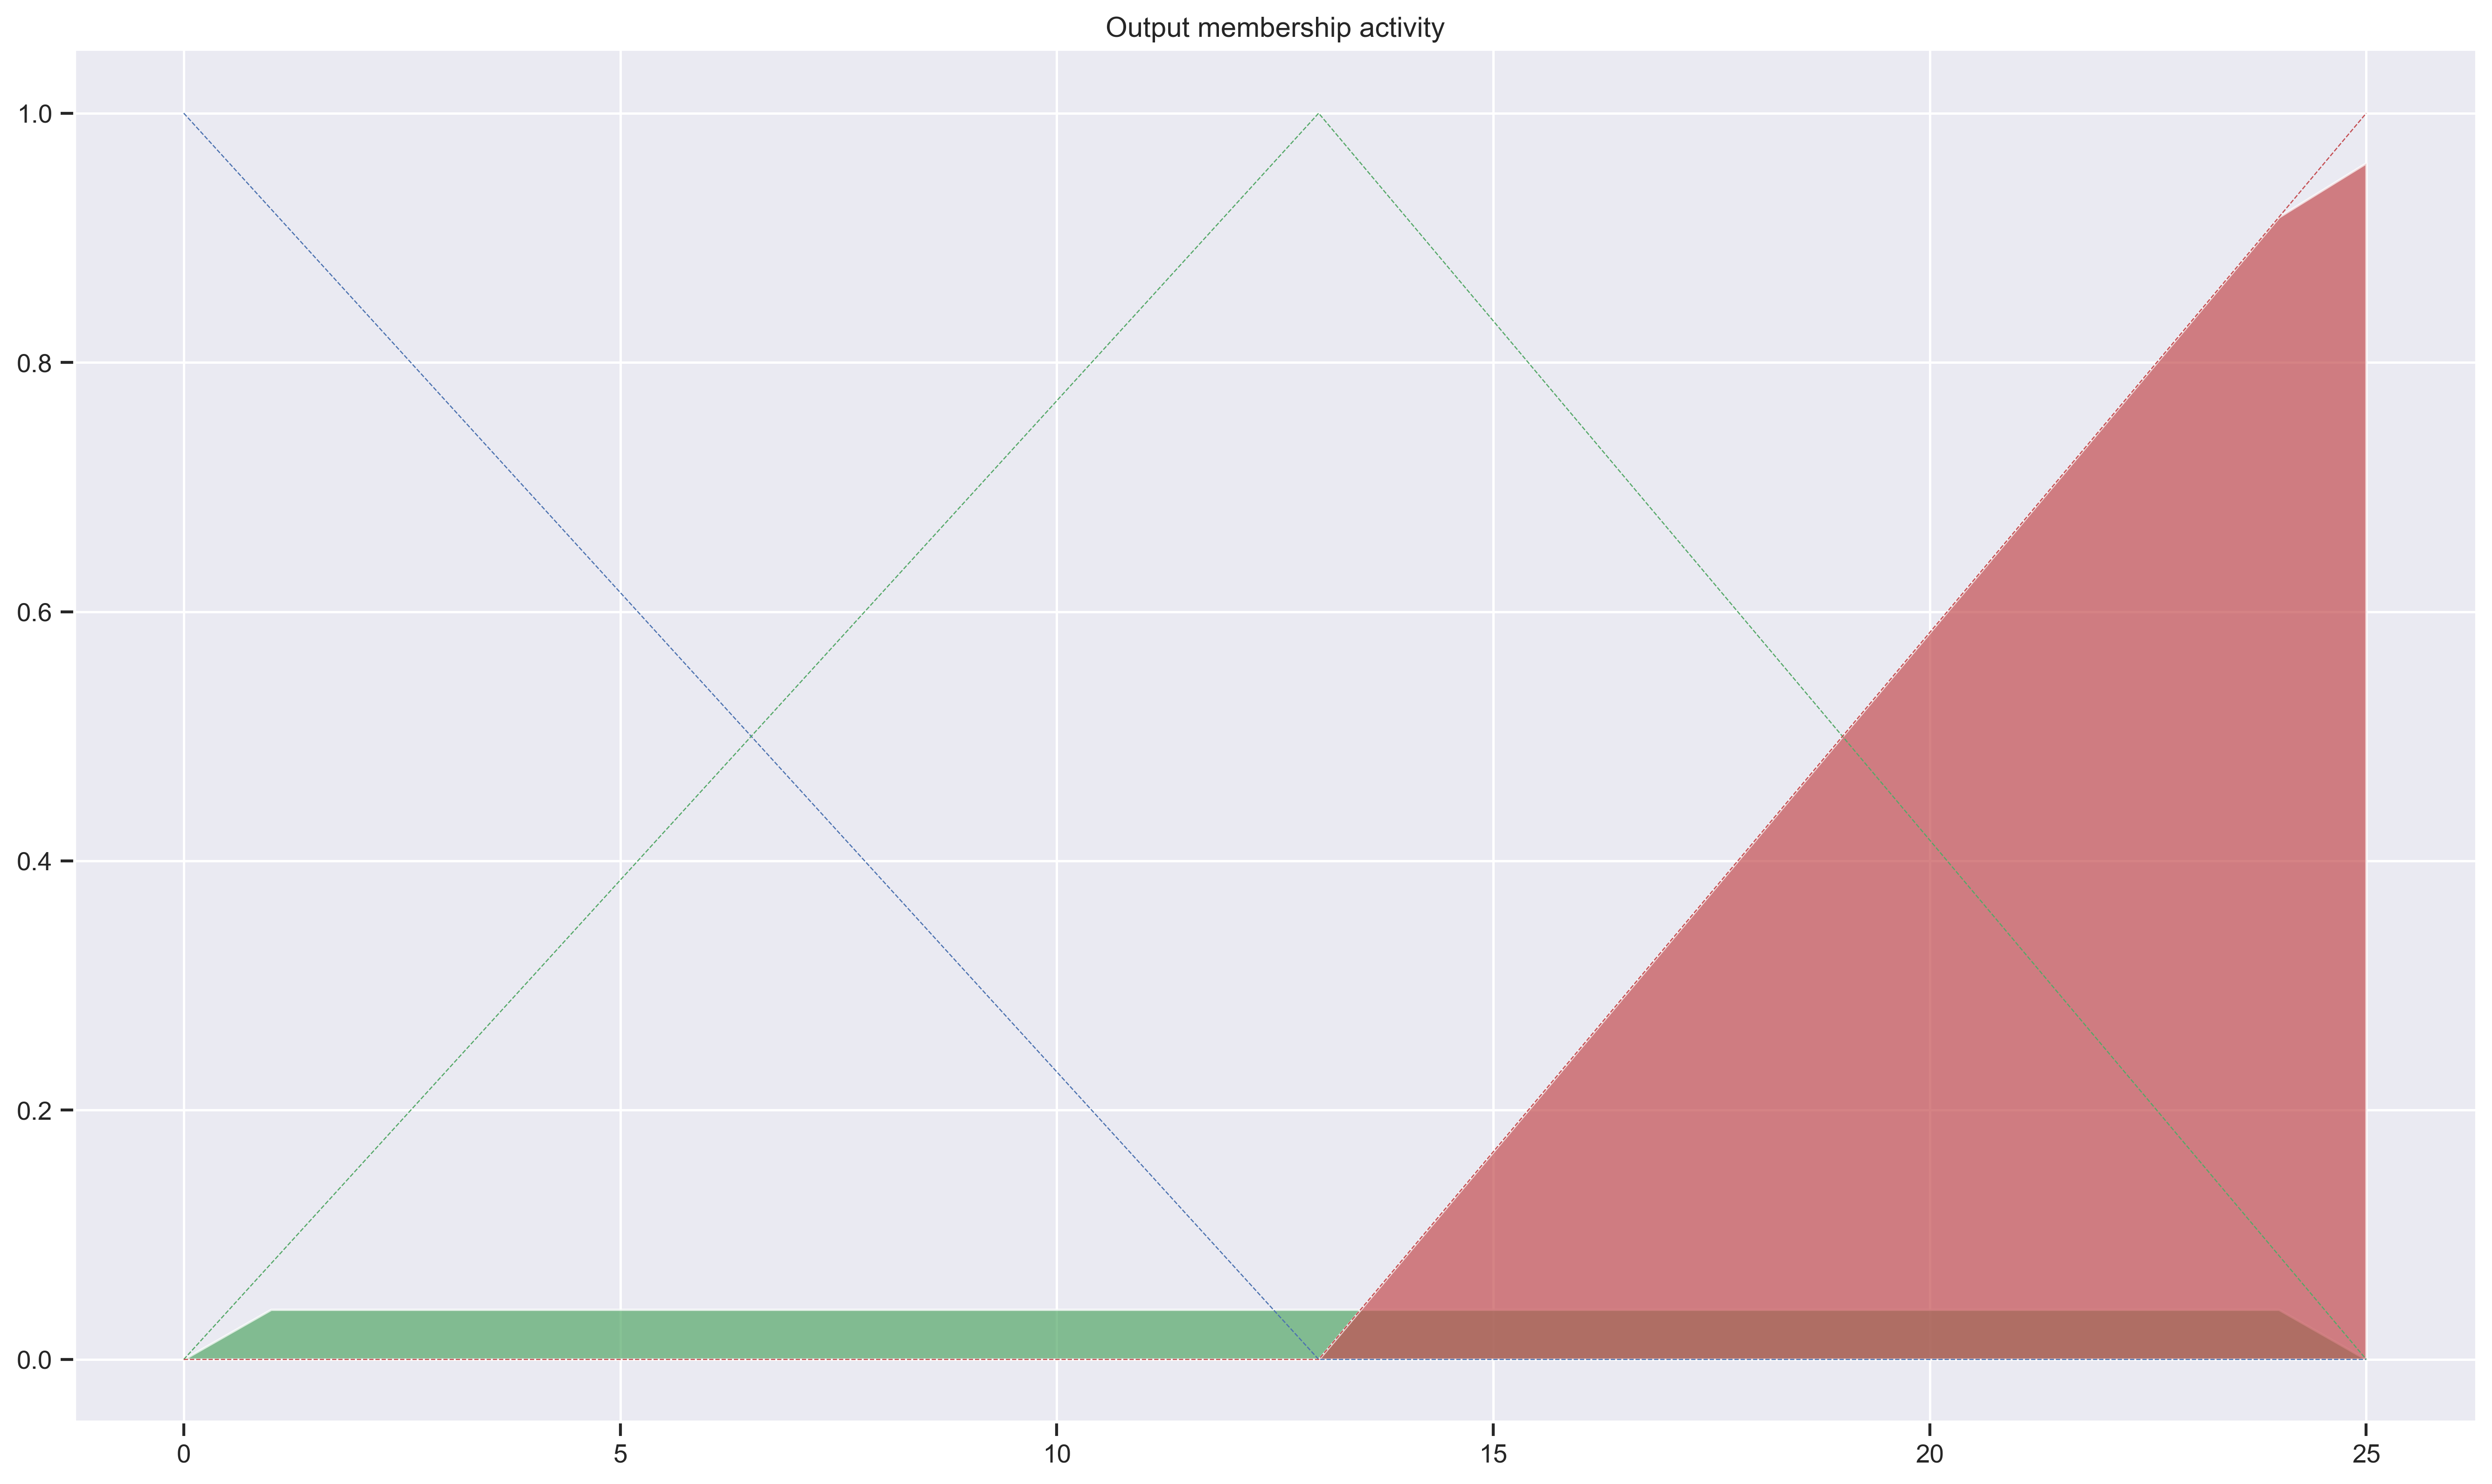

In [20]:
# We need the activation of our fuzzy membership functions at these values.
# The exact values 6.5 and 9.8 do not exist on our universes...
# This is what fuzz.interp_membership exists for!
qual_level_lo = fuzz.interp_membership(x_qual, qual_lo, 6.5)
qual_level_md = fuzz.interp_membership(x_qual, qual_md, 6.5)
qual_level_hi = fuzz.interp_membership(x_qual, qual_hi, 6.5)

serv_level_lo = fuzz.interp_membership(x_serv, serv_lo, 9.8)
serv_level_md = fuzz.interp_membership(x_serv, serv_md, 9.8)
serv_level_hi = fuzz.interp_membership(x_serv, serv_hi, 9.8)

# Now we take our rules and apply them. Rule 1 concerns bad food OR service.
# The OR operator means we take the maximum of these two.
active_rule1 = np.fmax(qual_level_lo, serv_level_lo)

# Now we apply this by clipping the top off the corresponding output
# membership function with `np.fmin`
tip_activation_lo = np.fmin(active_rule1, tip_lo)  # removed entirely to 0

# For rule 2 we connect acceptable service to medium tipping
tip_activation_md = np.fmin(serv_level_md, tip_md)

# For rule 3 we connect high service OR high food with high tipping
active_rule3 = np.fmax(qual_level_hi, serv_level_hi)
tip_activation_hi = np.fmin(active_rule3, tip_hi)
tip0 = np.zeros_like(x_tip)

# Visualize this
fig, ax0 = plt.subplots(figsize=(15, 9), dpi=360)

ax0.fill_between(x_tip, tip0, tip_activation_lo, facecolor='b', alpha=0.7)
ax0.plot(x_tip, tip_lo, 'b', linewidth=0.5, linestyle='--', )
ax0.fill_between(x_tip, tip0, tip_activation_md, facecolor='g', alpha=0.7)
ax0.plot(x_tip, tip_md, 'g', linewidth=0.5, linestyle='--')
ax0.fill_between(x_tip, tip0, tip_activation_hi, facecolor='r', alpha=0.7)
ax0.plot(x_tip, tip_hi, 'r', linewidth=0.5, linestyle='--')
ax0.set_title('Output membership activity')

# Turn off top/right axes
for ax in (ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()


با دانستن میزان تعلق به هر تابع تعلق (مجموعه) حال باید توابع تعلق را ترکیب کنیم. برای این کار از عملگرهای مختلفی 
می‌توان استفاده کرد. ما در این جا از عملگر بیشینه‌گیری (ماکسیمم) استفاده می‌کنیم. به این گام، گام

Aggregation

هم گفته می‌شود.

مرحله‌ی غیرفازی‌سازی یا همان

Defuzzification

به این صورت است که حال با داشتن مقادیر عددی، به منطق ساده‌ی خود یا همان منطق

Crisp

برمی‌گردیم. برای حساب کردن جواب نهایی، از توابع مختلفی مانند تابع مرکز جرم می‌توان استفاده کرد.

 تابع مرکز جرم به این صورت کار می‌کند که مجموع مساحت مورد نظر را تقسیم بر عرض سطح می‌کنی.
این متد، متد 

Centroid

نام دارد.

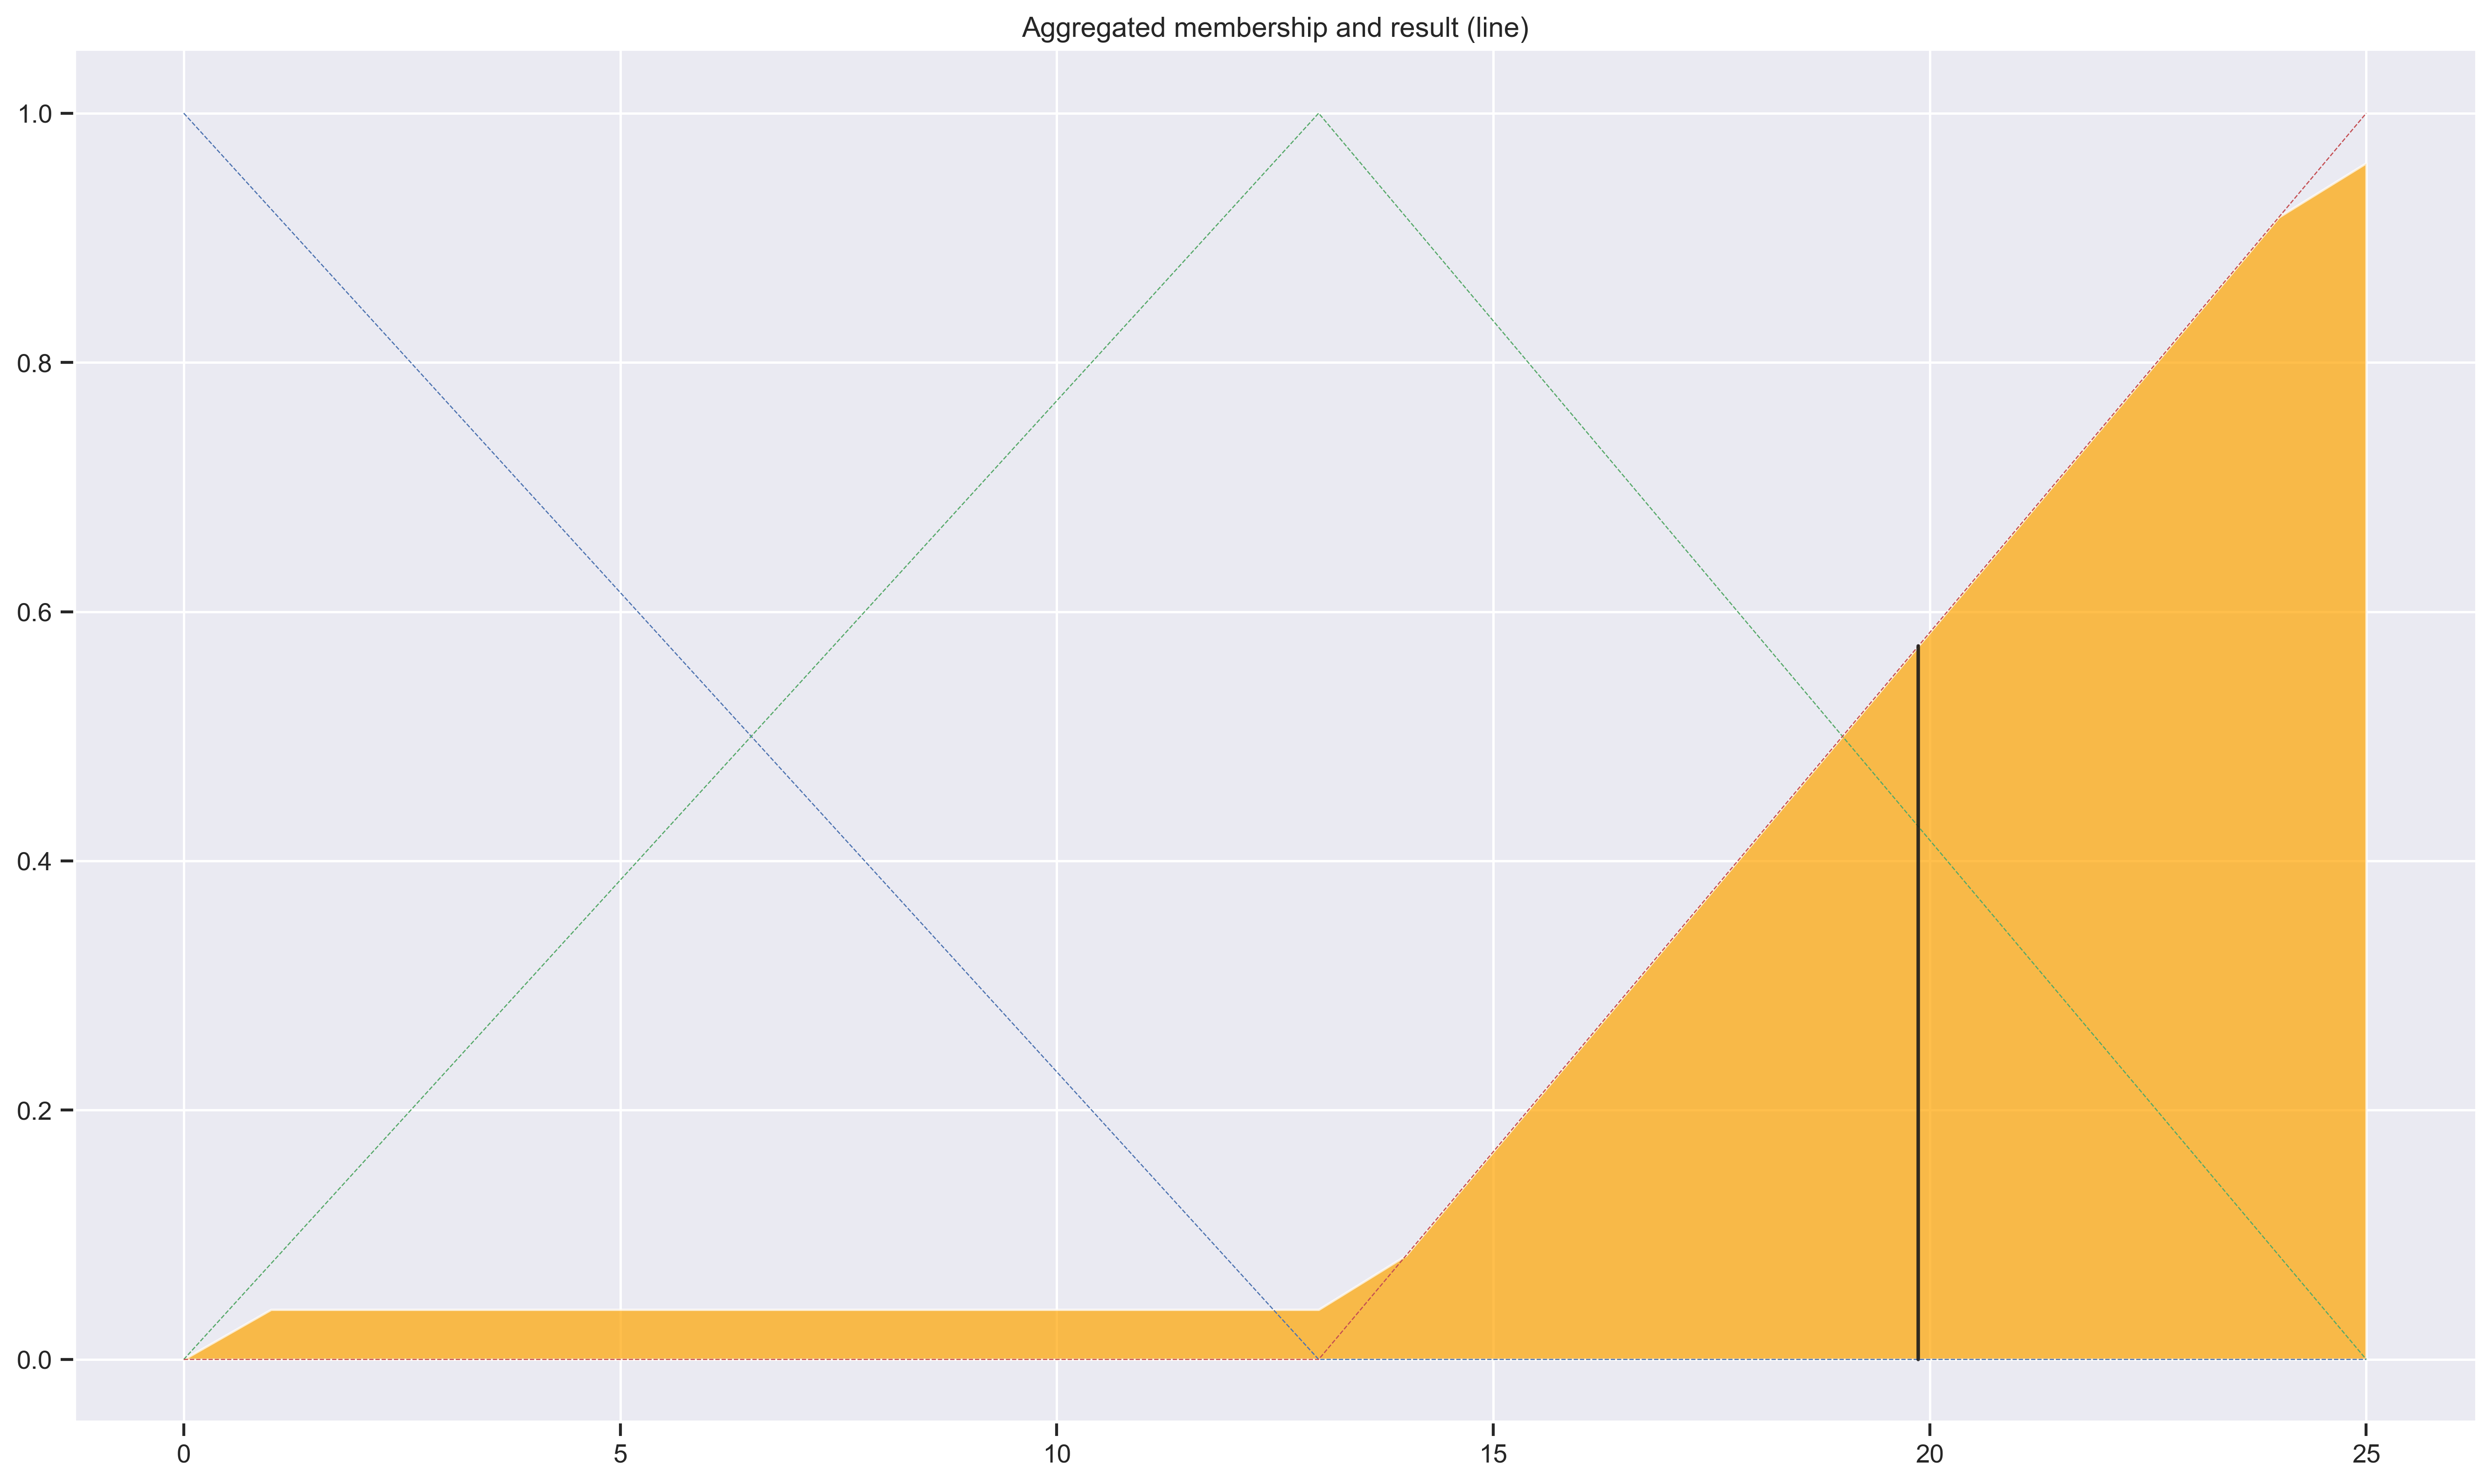

In [22]:
# Aggregate all three output membership functions together
aggregated = np.fmax(tip_activation_lo,
                     np.fmax(tip_activation_md, tip_activation_hi))

# Calculate defuzzified result
tip = fuzz.defuzz(x_tip, aggregated, 'centroid')
tip_activation = fuzz.interp_membership(x_tip, aggregated, tip)  # for plot

# Visualize this
fig, ax0 = plt.subplots(figsize=(15, 9), dpi=360)

ax0.plot(x_tip, tip_lo, 'b', linewidth=0.5, linestyle='--', )
ax0.plot(x_tip, tip_md, 'g', linewidth=0.5, linestyle='--')
ax0.plot(x_tip, tip_hi, 'r', linewidth=0.5, linestyle='--')
ax0.fill_between(x_tip, tip0, aggregated, facecolor='Orange', alpha=0.7)
ax0.plot([tip, tip], [0, tip_activation], 'k', linewidth=1.5, alpha=0.9)
ax0.set_title('Aggregated membership and result (line)')

# Turn off top/right axes
for ax in (ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

همان‌طور که مشخص است، مرکز جرم این مساحت، در نقطه‌ی

X = 20

قرار می‌گیرد.

در نتیجه می‌توان گفت میزان انعام برای شرایط مثال، برابر ۲۰٪ خواهد بود.